# Software Evolution - Practical Session
## Laws of software evolution, code counting, code duplication and dependency analysis
## Academic year 2022-2023

### Write your answers under the questions that are present in this notebook  

### Read Section 1 and Section 2 in the provided description document before proceeding with the following section 

In [21]:
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import math
from pandas import option_context
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_error

## 2. Verifying laws of software evolution

In [2]:
#Enter the path where the Eucalyptus project is present
eucalyptus_project_path = '../eucalyptus/'

### 2.1 Data prepocessing
1. Get all the tags present in the eucalyptus project using CLOC
2. Filter out the tags that do not correspond to official releases

Code hint:  
To get the tags that are present in the project - "command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'"   
To read the terminal output - 'process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)'

In [3]:
command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)"|sort -r'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

raw_tags = list(line.strip().decode('utf-8') for line in process.stdout)

In [4]:
tags = []
for tag in raw_tags:
    if 'alpha' in tag or 'beta' in tag or 'rc' in tag or 'm' in tag or 'branch' in tag or tag[-1].isalpha():
        continue
    
    if tag[0] == 'v':
        tag = tag[1:]
        
    if len(tag.split('.')) > 3:
        continue
    
    tags.append(tag)

major_minor_patch_versions = ['1.4','1.5.0','1.5.1','1.5.2','1.6.1','2.0.0','2.0.1','3.0.0','3.0.1','3.1.0','3.1.1','3.1.2','3.2.0','3.2.1',
                              '3.2.2','3.3.0','3.3.1','3.3.2','3.4.0','3.4.1','3.4.2','v4.0.0','v4.0.1','v4.0.2','v4.1.0','v4.1.1','v4.1.2',
                              'v4.2.0','v4.2.1','v4.2.2','v4.3.0','v4.3.1','v4.4.0','v4.4.1','v4.4.2']
major_minor_versions = ['1.4','1.5.0','1.6.1','2.0.0','3.0.0','3.1.0','3.2.0','3.3.0','3.4.0','v4.0.0','v4.1.0','v4.2.0','v4.3.0','v4.4.0']

### 2.2 Law of Increasing Growth
1. Fetch the required data (lines of code, blank lines, comment lines and number of files) for each tag along with their release date using CLOC
2. Separate the data as following (also mentioned in section 2.1 of the description document)  
    a) Consider all the three-component versions (major.minor.patch) - Dataset A  
    b) Consider only the minor versions (major.minor) - Dataset B  

Note: For example, if there exists any tag like 2.1.0.1, then you can consider it as 2.1.0 provided such a tag does not exist in the data. If both 2.1.0 and 2.1.0.1 exists, then you can ignore the latter 

Code hint:  
To set the project to a required tag - "command = f'git -C {project_path} reset --hard {tag}'"  
For each tag, pass the command to the terminal, invoke cloc tool to get the necessary data in the required format (json, md,...), read the terminal output and store the data

In [32]:
def extract(tags, language='Java'):
    df = []
    for i, tag in enumerate(tags):
        print(f'Processing {tag} ({i+1}/{len(tags)})', end='\r')
        
        command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        
        command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r' # to get the release date
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        
        release_date = list(line.strip().decode('utf-8') for line in process.stdout)
        for value in release_date:
            if value.startswith(tag):
                release_date = value.split('|')[1]
                break
        release_date = datetime.strptime(release_date, '%Y-%m-%d')
                
        command = f'cloc --json {eucalyptus_project_path}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        
        output = process.communicate()[0].decode('utf-8')
        
        for key, data in json.loads(output).items():
            if key == language:
                df.append({
                    'release date': release_date,
                    'tag': tag,
                    'lines of code': data['code'], 
                    'blank lines': data['blank'], 
                    'comment lines': data['comment'], 
                    'number of files': data['nFiles']
                })
                break
    
    return pd.DataFrame(df)

In [6]:
# Your code here to get the versions of the form major.minor 
dataset_B = extract(major_minor_versions)
dataset_B


1 error:
Line count, exceeded timeout:  ../eucalyptus/net/globalnetwork.c


,release date,tag,lines of code,blank lines,comment lines,number of files
0,2009-01-06,1.4,21281,4076,6750,235
1,2009-02-18,1.5.0,29898,5458,13558,295
2,2009-11-05,1.6.1,44375,7477,27525,469
3,2010-06-05,2.0.0,61700,9344,29019,686
4,2012-02-07,3.0.0,108162,17384,39347,1092
5,2012-06-22,3.1.0,110481,17863,41082,1099
6,2012-12-17,3.2.0,123796,20497,78890,1219
7,2013-06-20,3.3.0,165514,26729,87976,1484
8,2013-10-24,3.4.0,173606,27788,91737,1573
9,2014-05-30,v4.0.0,210843,33099,96395,1822


In [7]:
# Your code here to get the versions of the form major.minor.patch
dataset_A = extract(major_minor_patch_versions)
dataset_A


1 error:
Line count, exceeded timeout:  ../eucalyptus/net/globalnetwork.c


,release date,tag,lines of code,blank lines,comment lines,number of files
0,2009-01-06,1.4,21281,4076,6750,235
1,2009-02-18,1.5.0,29898,5458,13558,295
2,2009-08-05,1.5.1,35003,6280,13506,367
3,2009-08-17,1.5.2,33486,5912,7302,367
4,2009-11-05,1.6.1,44375,7477,27525,469
5,2010-06-05,2.0.0,52357,7984,25866,578
6,2010-07-06,2.0.1,65668,9845,29374,717
7,2012-02-07,3.0.0,108162,17384,39347,1092
8,2012-03-12,3.0.1,108832,17489,40156,1094
9,2012-06-22,3.1.0,110481,17863,41082,1099


#### Visualization
1. x-axis = version, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

2. x-axis = date, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

For easy comparison, place the plots with the versions on x-axis should be on the top (0,0) and (1,0) and their corresponding plots with date on the x-axis right below them (1,0) and (1,1) 

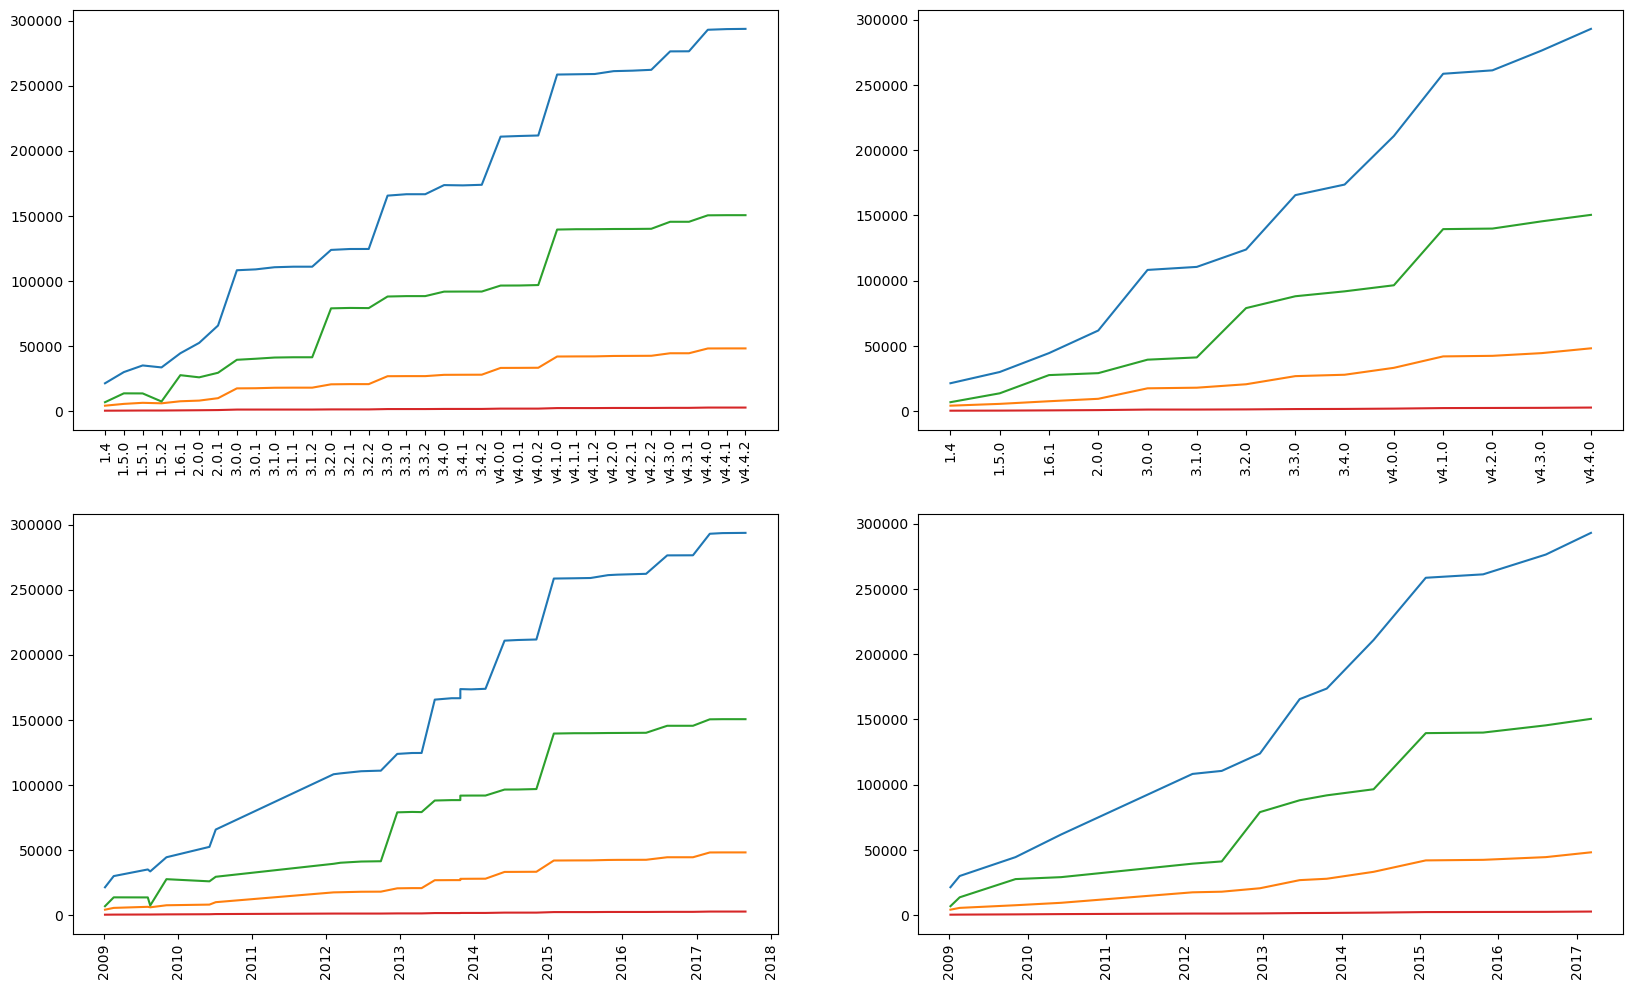

In [8]:
# Your plotting code here
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for x, type_name in enumerate(['tag', 'release date']):
    for y, df in enumerate([dataset_A, dataset_B]):
        axes[x, y].plot(df[type_name], df['lines of code'])
        axes[x, y].plot(df[type_name], df['blank lines'])
        axes[x, y].plot(df[type_name], df['comment lines'])
        axes[x, y].plot(df[type_name], df['number of files'])
        axes[x, y].tick_params(axis='x', rotation=90)
        
plt.show()  

### Questions:
1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

Yes there is a small difference. The second plot seems smoother since it takes into account the scale of time.

2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

It seems that the plot based on the date in x-axis is better since it takes into account the scale of time. 

3. Choose an option regarding the growth of the software by considering Dataset A. Motivate your choice using a 1d regression plot (below).  
    a) Linear  
    b) Sub-linear  
    c) Super-linear  

Answer A

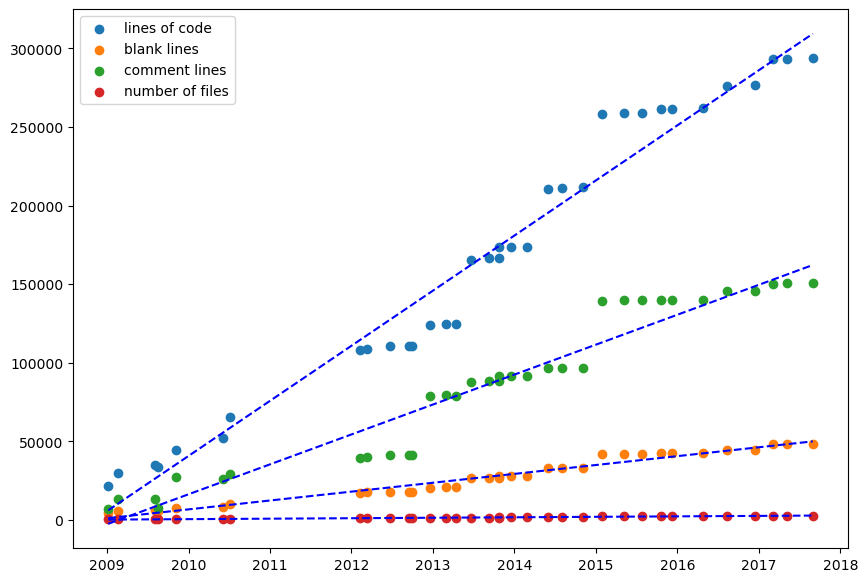

In [9]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 7))

def plot_for_tag(tag_name):
    plt.scatter(dataset_A['release date'], dataset_A[tag_name], label=tag_name)

    x = mdates.date2num(dataset_A['release date'])
    y = dataset_A[tag_name]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(dataset_A['release date'], p(x), "b--")
    
plot_for_tag('lines of code')
plot_for_tag('blank lines')
plot_for_tag('comment lines')
plot_for_tag('number of files')
plt.legend()
plt.show()

### Correlation 
Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering Dataset A. Report the correlation upto 3 decimal places

In [10]:
def spearman_correlation(x, y):
    return round(x.corr(y, method='spearman'), 3)

def pearson_correlation(x, y):
    return round(x.corr(y, method='pearson'), 3)

spearman_res = spearman_correlation(dataset_A['lines of code'], dataset_A['number of files'])
pearson_res = pearson_correlation(dataset_A['lines of code'], dataset_A['number of files'])

print(f'Spearman correlation: {spearman_res}')
print(f'Pearson correlation: {pearson_res}')

Spearman correlation: 0.999
Pearson correlation: 0.998


### Questions:
4. Do you find any difference in correlation values between Pearson and Spearman? Which one is preferable for this use case? why?

The difference is very subtle and the Spearman method show a small difference of 0.01. The Spearman method seems more useful since it does not only take into account the linearity correlation, but also the correlation in the sense of monotonic functions, thus increasing or decreasing.

5. Based on the above correlation value, how much is the number of lines of code related to the number of files?

At 99.9%.

### Prediction
Consider Dataset A for this task. Drop the last two data points in "number of lines of code" (LOC) (i.e. drop (LOC) corresponding to v4.4.1 and v4.4.2) and forecast the values for (LOC) for v4.4.1 and v4.4.2 using a basic linear/polynimial regression model.
1. Drop the last two data points
2. Build a basic regression model
3. Ask the model to forecast the next two data points
4. Plot the LOC original and forecasted in the same plot. x-axis = date, y-axis = number of lines of code

In [23]:
def get_model_and_dataset(polynomial_degree):
    test_df = dataset_A.loc[(dataset_A['tag'] == 'v4.4.2') | (dataset_A['tag'] == 'v4.4.1')]
    train_df = dataset_A.drop(test_df.index)

    train_X = mdates.date2num(train_df['release date'].copy()).reshape(-1, 1)
    train_X = PolynomialFeatures(degree=polynomial_degree, include_bias=False).fit_transform(train_X)
    train_y = train_df['lines of code']

    test_X = mdates.date2num(test_df['release date'].copy()).reshape(-1, 1)
    test_X = PolynomialFeatures(degree=polynomial_degree, include_bias=False).fit_transform(test_X)
    test_y = test_df['lines of code']
    
    model = LinearRegression()
    model.fit(train_X, train_y)
    
    return model, train_X, train_y, test_X, test_y

In [24]:
for polynomial_degree in range(1, 6):
    model, train_X, train_y, test_X, test_y = get_model_and_dataset(polynomial_degree)
    print(f'Polynomial degree: {polynomial_degree}')
    print(f'Train score: {model.score(train_X, train_y)}')
    print(f'Test score: {model.score(test_X, test_y)}')
    print()

Polynomial degree: 1
Train score: 0.9617485531155203
Test score: -24915.263982100718

Polynomial degree: 2
Train score: 0.9699161050404927
Test score: -148109.86667757216

Polynomial degree: 3
Train score: 0.980902608017462
Test score: -514.0869795713543

Polynomial degree: 4
Train score: 0.9815395708880412
Test score: -146.01549517847403

Polynomial degree: 5
Train score: 0.9821430627308182
Test score: -1487.2098070934312



In [27]:
polynomial_degree = 4
model, train_X, train_y, test_X, test_y = get_model_and_dataset(polynomial_degree)

In [28]:
all_X = mdates.date2num(dataset_A['release date'].copy()).reshape(-1, 1)
all_X = PolynomialFeatures(degree=polynomial_degree, include_bias=False).fit_transform(all_X)
all_y = dataset_A['lines of code']

predict_y = model.predict(all_X)

res_df = dataset_A[['release date', 'tag', 'lines of code']].copy()
res_df['predicted lines of code'] = predict_y
res_df.head()

,release date,tag,lines of code,predicted lines of code
0,2009-01-06,1.4,21281,35101.770550
1,2009-02-18,1.5.0,29898,34355.138160
2,2009-08-05,1.5.1,35003,34215.812863
3,2009-08-17,1.5.2,33486,34368.754394
4,2009-11-05,1.6.1,44375,35917.605770


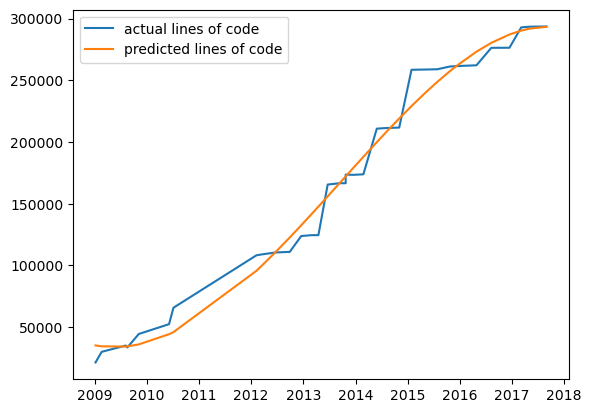

In [29]:
plt.figure()
plt.plot(res_df['release date'], res_df['lines of code'], label='actual lines of code')
plt.plot(res_df['release date'], res_df['predicted lines of code'], label='predicted lines of code')
plt.legend()
plt.show()

In [30]:
y_pred_test = model.predict(test_X)

r2 = r2_score(test_y, y_pred_test)
root_mse = np.sqrt(mean_squared_error(test_y, y_pred_test))

print(f'R2: {r2}')
print(f'Root MSE: {root_mse}')

R2: -146.01549517847403
Root MSE: 1079.1245235415108


### Questions:
6. What is the polynomial degree that you adopted to build the model? Why? 

4 because it seems to better fit the current data that we had and it has the best scoring in our evaluation.

7. What is the coefficient of determination? (R-squared)

R2: -146.01549517847403

8. What is the Root mean square error for the forecasted values?

Root MSE = 1079.1245235415108

### Filtering on coding language

Consider the prominent languages used in this software project and plot the distribution of their LOC in a pie chart for the first and the last versions

In [40]:
# Your code to get the data for LOC of first and last versions
def extract_all_loc(tags):
    df = []
    for i, tag in enumerate(tags):
        print(f'Processing {tag} ({i+1}/{len(tags)})', end='\r')
        
        command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        
        command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r' # to get the release date
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        
        release_date = list(line.strip().decode('utf-8') for line in process.stdout)
        for value in release_date:
            if value.startswith(tag):
                release_date = value.split('|')[1]
                break
        release_date = datetime.strptime(release_date, '%Y-%m-%d')
                
        command = f'cloc --json {eucalyptus_project_path}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        
        output = process.communicate()[0].decode('utf-8')
        
        value = {'release date': release_date, 'tag': tag}
        for key, data in json.loads(output).items():
            if 'code' in data:
                value[key] = data['code']
        df.append(value)

    return pd.DataFrame(df)

In [42]:
df = extract_all_loc(major_minor_patch_versions)
df.head()


1 error:
Line count, exceeded timeout:  ../eucalyptus/net/globalnetwork.c


,release date,tag,Java,Bourne Shell,C,XML,Groovy,Web Services Description,C/C++ Header,Perl,...,INI,Maven,JavaScript,Python,XSLT,CSV,JSON,SVG,Markdown,YAML
0,2009-01-06,1.4,21281,9866,8914,3113,1766,1139,575,452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-02-18,1.5.0,29898,9874,11701,5243,2012,1343,647,836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-08-05,1.5.1,35003,7223,12676,6335,2218,1438,693,940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-08-17,1.5.2,33486,7221,14201,6759,2297,1440,1017,940,...,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-11-05,1.6.1,44375,10928,15087,5029,4548,1443,1148,977,...,20.0,1005.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


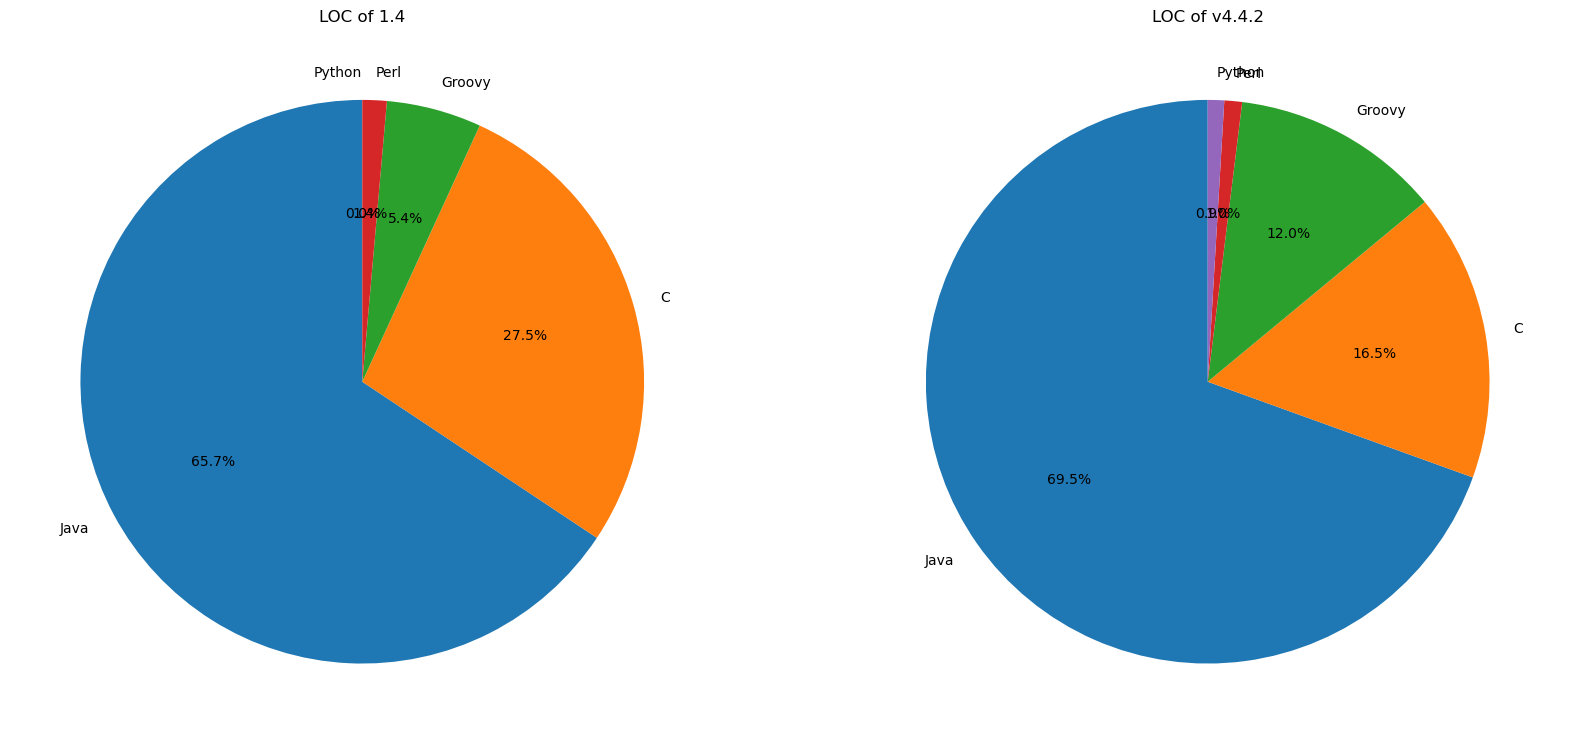

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
prominent_languages = ['Java', 'C', 'Groovy', 'Perl', 'Python']

for i, j in enumerate([0, len(df) - 1]):
    release_df = df.iloc[j][prominent_languages].fillna(0)
    release_df.sort_values(ascending=False, inplace=True)

    labels = release_df.keys()
    sizes = release_df.values

    axes[i].set_title(f'LOC of {df.iloc[j]["tag"]}')
    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    
plt.show()

### Question:
9. Do you find any significant difference in the distribution of the language used in the software project between its first and the last version? If so, what is the difference and how much is it?

Python started to be used during the project. Similarly, Groovy was used a little more compared to C which was used less throughout the project. Java and Perl still have the same number of uses.

### Law of increasing growth for coding languages

Get the LOC for each of the considered prominent languages (as above) for each version of the form major.minor.patch  
1) Plot the date (x-axis) vs LOC (y-axis) 
2) Plot the date (x-axis) vs proportional LOC (y-axis). Proportional is LOC of a language/total number of LOC

In [64]:
# Your code to get the LOC for each prominent language of each version
prominent_languages_df = df[['release date'] + prominent_languages].fillna(0)
prominent_languages_df.head()

,release date,Java,C,Groovy,Perl,Python
0,2009-01-06,21281,8914,1766,452,0.0
1,2009-02-18,29898,11701,2012,836,0.0
2,2009-08-05,35003,12676,2218,940,0.0
3,2009-08-17,33486,14201,2297,940,0.0
4,2009-11-05,44375,15087,4548,977,0.0


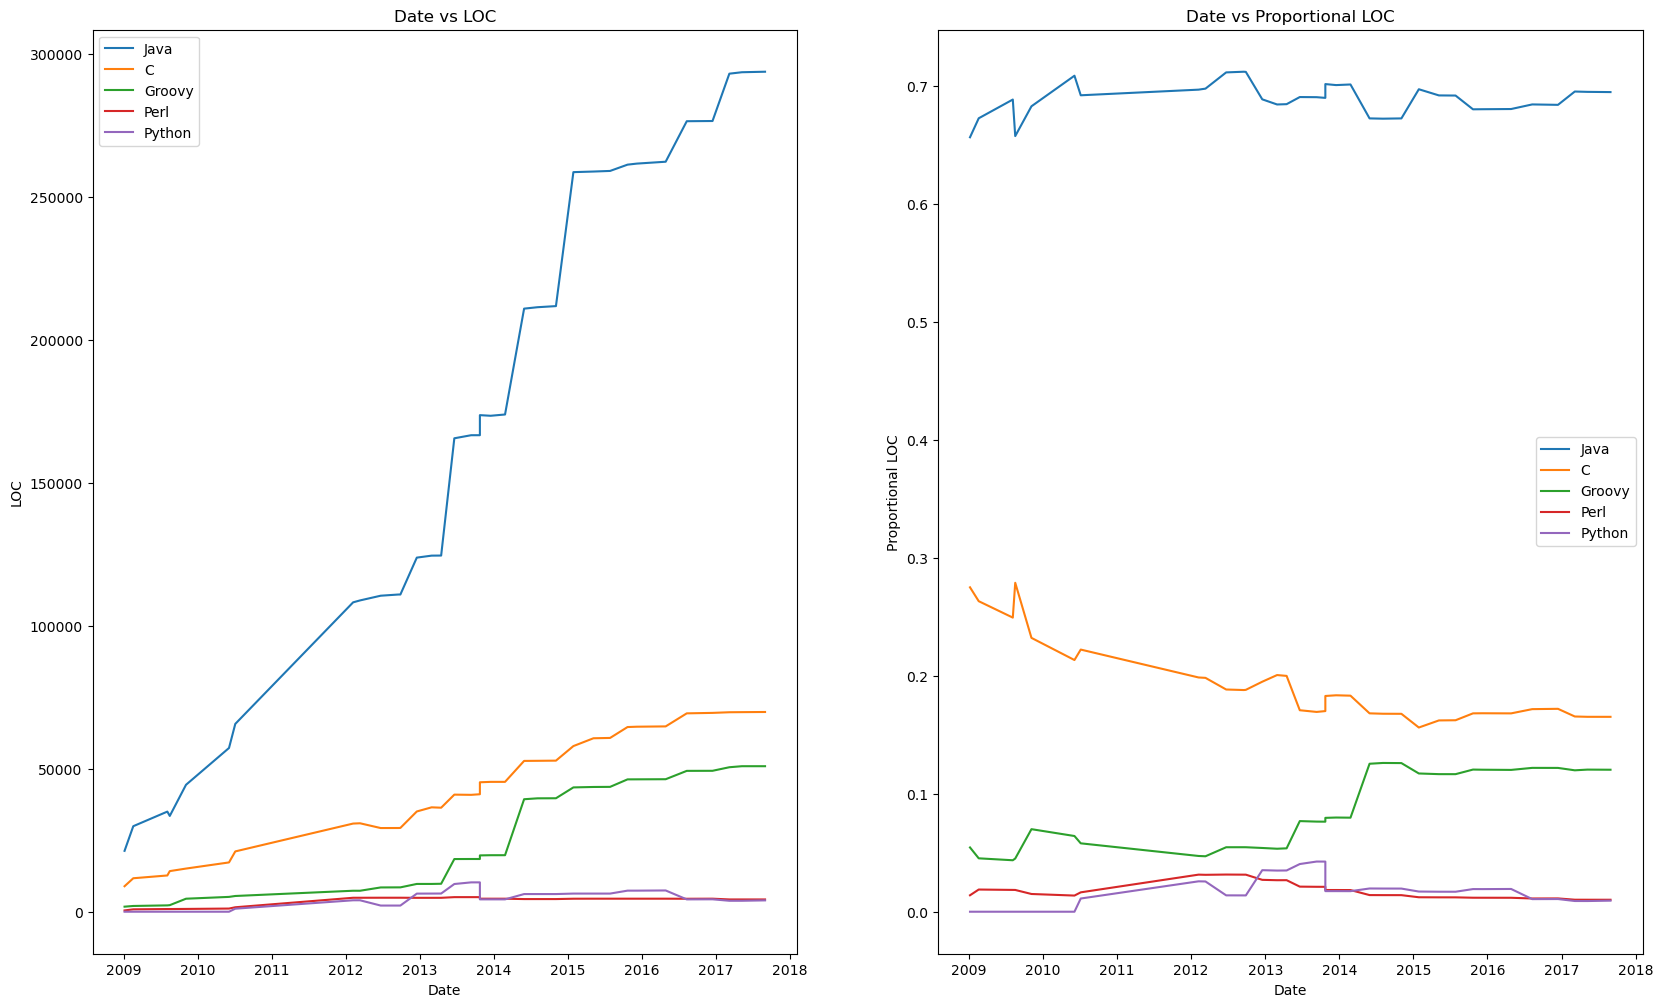

In [71]:
# Your plotting code here
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# 1. Date vs LOC
axes[0].set_title('Date vs LOC')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('LOC')
for language in prominent_languages:
    axes[0].plot(prominent_languages_df['release date'], prominent_languages_df[language], label=language)
axes[0].legend()

# 2. Date vs Proportional LOC
axes[1].set_title('Date vs Proportional LOC')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Proportional LOC')

proportional_loc = {}
for idx, row in prominent_languages_df.iterrows():
    for language in prominent_languages:
        if language not in proportional_loc:
            proportional_loc[language] = []
        proportional_loc[language].append(row[language] / row[prominent_languages].sum(axis=0))
    
for language in prominent_languages:
    axes[1].plot(prominent_languages_df['release date'], proportional_loc[language], label=language)
axes[1].legend()        

plt.show()  

### Question:
10. Does the prominent languages considered by you obey laws of increasing growth?

Yes because the number of line of code is increasing with the versions. Also the proportional LOC seems to remain constant throughout the version.

11. Does this software project obey the Law of Increasing Growth?

Yes as the prominent languages constituing this software are obeying the laws of increasing growth.

### Modify the CLOC parameters

1. Exclude all bank lines and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here

2. Exclude all comment lines and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here

3. Exclude all non-code files (or consider prominent coding langugages used in the project) and and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here

### 2.3 Law of Continuing Change
1. Using CLOC tool, find the features such as number of lines of code that are added, modified, removed and same between two consecutive versions
2. Consider all the three component versions (major.minor.patch) - Dataset A
3. Consider only the minor versions (major.minor) - Dataset B
4. Having all the features in the same plot, create two plots (one for Dataset A and another for Dataset B) the outcomes with date on x-axis and the number on y-axis.
5. Make a subplot of all the features

Code hint:  
For each pair of tags, set the original project to the required tag and the copy of the original project to the next tag.  
To get the required data in json format - "command = f'CLOC/cloc --git --diff {first_project_path} {second_project_path} --json'"

In [ ]:
eucalyptus_project_path = '' # your project path here
eucalyptus_copy_project_path = '' # your path to the copy of your project here
major_minor_patch_versions = '' #set of version that you would like to consider for this analysis

In [ ]:
# Your code here to get the data

In [ ]:
# Your code here to get the dates corresponding to the tags

In [ ]:
# Your plotting code here (all the features in a single plot)

In [ ]:
# Your plotting code here, different plot for each feature
fig,axes = plt.subplots(2,2)

### Questions:
1. Do you find the Law of Continuing Change holding good here? Prove it empirically.

2. Does the law of increasing growth too hold good here?

### Law of continuing change for coding languages
Consider the prominent languages used in this software project for versions of the form major.minor.patch
1. Obtain the number of lines of code that are added, modified, removed and same between two consecutive versions
2. Make plots for each parameter (added, modified, removed and same) with date on x-axis  
    a) y-axis number of lines of code   
    b) y-axis proportional number of lines of code (number of lines of code of that language/total number of lines of code) 

In [ ]:
# Your code here

In [ ]:
# Your plotting code here
fig,axes = plt.subplots(2,2)

### Question:
3. Does the law of continuing change obey here for all the considered prominent langugages? Comment on the rate of growth.  

4. Does this software project obey Law of Continuing Change?